## BE485, Lab 13, Ex 1: NDVI Timeseries
 In this exercise:<br>
 a) Read multiple <font color="red">HDF</font> data files<br>
 b) Extract timeseries by pixel and landcover<br>
 c) Summarize dataset into yearly<br>
 d) Compute yearly anomalies<br>

In [1]:
# Import all necessary libraries

import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import warnings

# Library for reading HDF files
from pyhdf.SD import SD, SDC

#Import the VIP Library
import viplab_lib5 as vip

# This is a magic function call that renders the figure in a notebook
# instead of displaying a dump of the figure object
%matplotlib inline

print("Current working directory:")
print(os.getcwd())

Current working directory:
C:\Users\theboss\BE485\Lab\Lab-13-Code


## User defined functions

In [2]:
# user defined functions

# reads one band from and HDF file
def HDFread_band(filename,bandname):
    print("Reading", bandname," from ",filename)
    hdf = SD(filename, SDC.READ)
    
    sds= hdf.select(bandname)
    bandX=sds.get()
    hdf.end()
    return bandX

#gets the average from a 2d band using a mask
def band_mask_getAvg(band,Mask,minval,maxval,fillvalue=-15000): 
    data=band[ (band>=minval) & (band<=maxval) & (Mask==True)]
    count=len(data)    
    if(count>0):
        average= np.mean(data) 
    else:
        average=fillvalue
    
    return average


#extracts timeseries using a mask
def getTimeSeries_Masked(DataArray, bandMask, vmin, vmax, fillvalue=-15000):
    nrows,ncols,nlayers=DataArray.shape
            
    datalist=[]
    for k in range(0,nlayers):
       value=band_mask_getAvg(DataArray[:,:,k],bandMask,vmin,vmax,fillvalue) 
       datalist.append(value) 
       
    return datalist

#custom function to read NDVI and RANK
#and calculate NDVI
def HDFread_VIS(filename,showfname=False):
    
    if(showfname):
       print("Reading ",filename)
          
    hdf = SD(filename, SDC.READ)
    
    sdsNDVI= hdf.select('1 km 16 days NDVI')
    bandNDVI=sdsNDVI.get()
    sdsRANK= hdf.select('1 km 16 days pixel reliability')
    bandRANK=sdsRANK.get()
    
    hdf.end()
    return bandNDVI, bandRANK


def Compute_NDVI_Yearly(DataArray, RankArray, indexA, indexB, vmin, vmax, fillvalue):
    #loop each pixel to get AVGs
    nrows,ncols,nlayers=DataArray.shape
    
    DataRes=np.zeros((nrows,ncols))
    indexB2=indexB+1    
    for i in range(0,nrows):
       for j in range(0,ncols):
           
           datalist=[]
           kcount=0
           for k in range(indexA,indexB2):
               value=DataArray[i,j,k]
               rankPixel=RankArray[i,j,k]
               if(rankPixel==0 or rankPixel==1 or rankPixel==2):
                   if(value>=vmin and value<=vmax):
                       datalist.append(value)
                       kcount=kcount+1
           
           if(kcount>0):
               avg=np.mean(datalist)
           else:
               avg=fillvalue
    
           DataRes[i,j]=avg
       
    return DataRes

def Compute_NDVI_Yearly2(DataArray, RankArray, indexA, indexB, vmin, vmax, fillvalue):
    #loop each pixel to get AVGs
    nrows,ncols,nlayers=DataArray.shape
    
    indexB2=indexB+1
    nlays=indexB2-indexA
    DataCube=np.zeros((nrows,ncols,nlays))
    i=0
    for k in range(indexA,indexB2):
        value=DataArray[:,:,k]
        rankPixel=RankArray[:,:,k]      
        value2=np.where((value<vmin) | (value>vmax), np.nan, value)
        
        DataCube[:,:,i]=np.where((rankPixel==0) | (rankPixel==1) | (rankPixel==2), value2, np.nan) 
        i=i+1
    with warnings.catch_warnings():
       warnings.simplefilter("ignore", category=RuntimeWarning)
       DataRes=np.nanmean(DataCube, axis=2) 
    DataRes[DataRes==np.nan]=fillvalue
    return DataRes


def Compute_AVG_STDEV(DataArray, vmin, vmax, fillvalue):
    #loop each pixel to get AVGs
    nrows,ncols,nlayers=DataArray.shape
    
    DataAvg=np.zeros((nrows,ncols))
    DataStdev=np.zeros((nrows,ncols))
    for i in range(0,nrows):
       for j in range(0,ncols):
           
           datalist=[]
           kcount=0
           for k in range(0,nlayers):
               value=DataArray[i,j,k]
               if(value>=vmin and value<=vmax):
                   datalist.append(value)
                   kcount=kcount+1
           
           if(kcount>0):
               avg=np.mean(datalist)
               stdev=np.std(datalist)
           else:
               avg=fillvalue
               stdev=fillvalue
           
           DataAvg[i,j]=avg
           DataStdev[i,j]=stdev
       
    return DataAvg,DataStdev

def Compute_AVG_STDEV2(DataArray, vmin, vmax, fillvalue):
    #loop each pixel to get AVGs
    nrows,ncols,nlayers=DataArray.shape
    
    DataCube=np.zeros((nrows,ncols,nlayers))
    
    for k in range(0,nlayers):
        value=DataArray[:,:,k]    
        value2=np.where((value<vmin) | (value>vmax), np.nan, value)
        DataCube[:,:,k]=value2
        
    with warnings.catch_warnings():
       warnings.simplefilter("ignore", category=RuntimeWarning)    
       DataAvg=np.nanmean(DataCube,axis=2)
       DataStdev=np.nanstd(DataCube,axis=2)   
    return DataAvg,DataStdev

## Main program starts here !
## 1. Define and read input data file

In [3]:
# start of main script

# define input data

# MODIS Files
# index: datatype : band name
#  0 : INT16  : 1 km 16 days NDVI
#  1 : UINT16 : 1 km 16 days VI Quality
#  2 : INT16  : 1 km 16 days composite day of the year
#  3 : INT8   : 1 km 16 days pixel reliability

#dataset has been reduced to 300x300 because you will be processing 19 years of data
nrows=300
ncols=300
FILL_VI=-3000
fmulti=0.0001
NDVImin=-2000
NDVImax=10000

CYCLES_YEAR=23
NYEARS=19
NLAYERS=CYCLES_YEAR * NYEARS

print("Dataset: Nyears=",NYEARS,", Cycles per year=",CYCLES_YEAR)
print("Reading ", NLAYERS," layers of data it will take a few minutes...")


#create band arrays to store 16day composite images images
NDVICube=np.zeros((nrows,ncols,NLAYERS),np.int16)
RANKCube=np.zeros((nrows,ncols,NLAYERS),np.int8)     

#list of days 
DOYList=['001','017','033','049','065','081','097','113','129','145','161','177',
         '193','209','225','241','257','273','289','305','321','337','353']

#data location for this excercise
dataPath='./data_C16/'

print("Reading data:")
startTime=vip.startTime()
k=0
lastyear=2001+NYEARS
for y in range(2001,lastyear):
    print(' ',y,end="") 
    for i in range(0,23):
        DOY=DOYList[i]
        #create filename
        
        #read HDF files
        filename=dataPath+'MOD13A2.A'+str(y)+DOY+'.h08v05.006.subset.hdf'
        NDVI,RANK=HDFread_VIS(filename,False)
        
        #store in daily array
        NDVICube[:,:,k]=NDVI
        RANKCube[:,:,k]=RANK
        k=k+1
    
vip.endTime(startTime,"\nDone: ")

Dataset: Nyears= 19 , Cycles per year= 23
Reading  437  layers of data it will take a few minutes...
Reading data:
  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
Done:  5.37  seconds


In [5]:
NDVICube.shape

(300, 300, 437)

## 1. Extract Timeseries NDVI for a pixel

Time series for One Year and for the full period
.


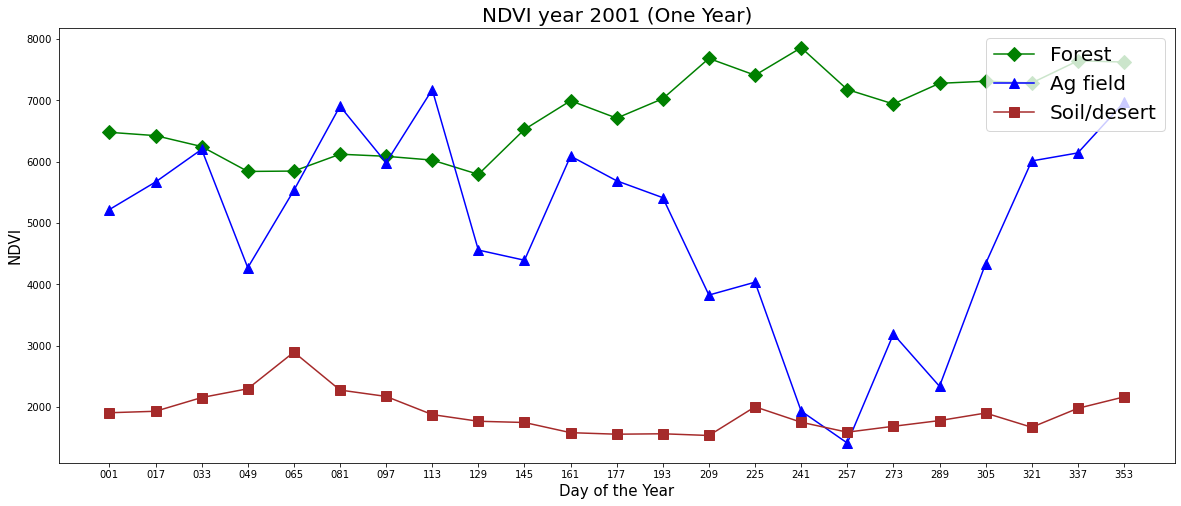

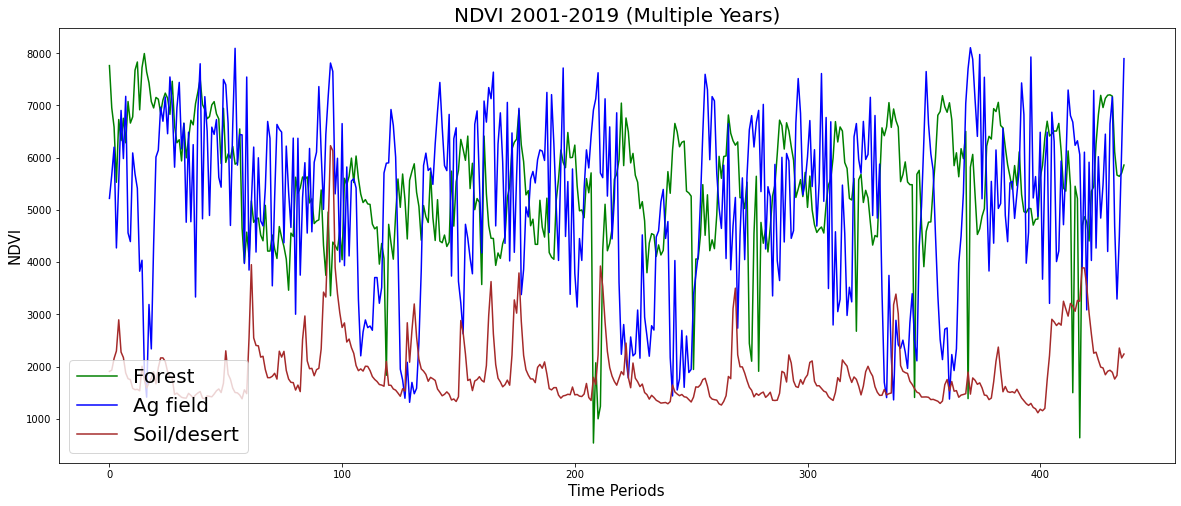

In [6]:
print("Time series for One Year and for the full period")

#23 points per year
TSndvi_Forest=NDVICube[226,242,0:23]
TSndvi_Ag=NDVICube[48,62,0:23]
TSndvi_Soil=NDVICube[221,100,0:23]

# Plot the data
plt.figure(figsize=(20,8))
plt.title('NDVI year 2001 (One Year)',fontsize=20)
plt.ylabel('NDVI',fontsize=15)
plt.xlabel('Day of the Year',fontsize=15)

# For info on markers consult https://www.w3schools.com/python/matplotlib_markers.asp

plt.plot(DOYList,TSndvi_Forest,color='green',label='Forest',marker = 'D', ms = 10)
plt.plot(DOYList,TSndvi_Ag,color='blue',label='Ag field',marker = '^', ms = 10)
plt.plot(DOYList,TSndvi_Soil,color='brown',label='Soil/desert',marker = 's', ms = 10)
plt.legend(fontsize=20, loc='upper right')

# for the full period
TSndvi_Forest=NDVICube[228,245,:]
TSndvi_Ag=NDVICube[48,62,:]
TSndvi_Soil=NDVICube[221,100,:]

plt.figure(figsize=(20,8))
plt.title('NDVI 2001-2019 (Multiple Years)', fontsize=20)
plt.ylabel('NDVI',fontsize=15)
plt.xlabel('Time Periods',fontsize=15)
plt.plot(TSndvi_Forest,color='green',label='Forest')
plt.plot(TSndvi_Ag,color='blue',label='Ag field')
plt.plot(TSndvi_Soil,color='brown',label='Soil/desert')

plt.legend(fontsize=20, loc='lower left')
print(".")

## 2. Read a Land Cover file (Type I), apply a special color table, and Display it

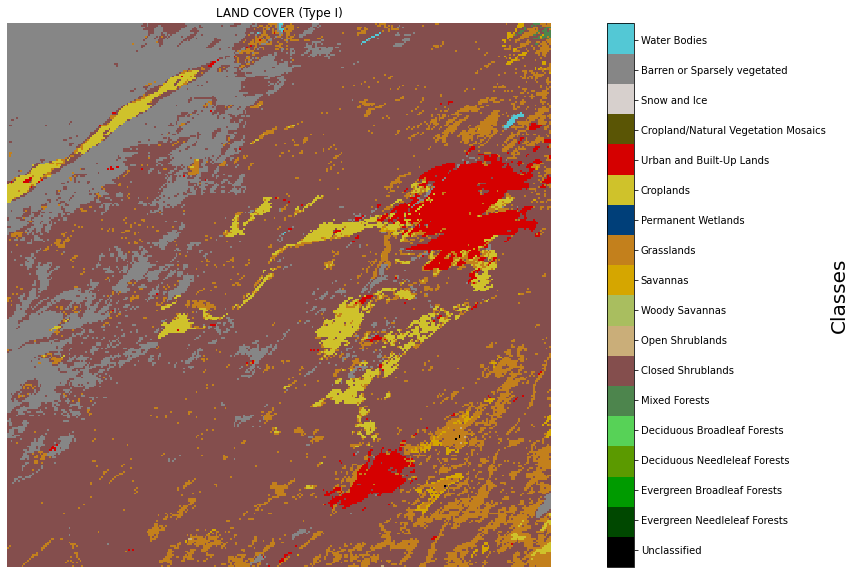

Land Cover Type I: file: MCD12Q1.A2017001.h08v05.006.LC.bsq


In [7]:
#LCover labels

LC_Label=[
"Unclassified",
"Evergreen Needleleaf Forests",
"Evergreen Broadleaf Forests",
"Deciduous Needleleaf Forests",
"Deciduous Broadleaf Forests",
"Mixed Forests",
"Closed Shrublands",
"Open Shrublands",
"Woody Savannas",
"Savannas",
"Grasslands",
"Permanent Wetlands",
"Croplands",
"Urban and Built-Up Lands",
"Cropland/Natural Vegetation Mosaics",
"Snow and Ice",
"Barren or Sparsely vegetated",
"Water Bodies"

]
# Next setup a colormap for our map
LC_Colors = dict((
(1, (0,0,0,255)),
(2, (0,72,0,255)),  
(3, (0,155,0, 255)),  
(4, (91,154,0, 255)), 
(5, (87,210,87, 255)), 
(6, (77,133,77, 255)), 
(7, (132,78,77, 255)), 
(8, (202,174,121, 255)),
(9, (169,190,95, 255)), 
(10, (213,166,0, 255)), 
(11, (195,128,28, 255)),
(12, (0,63,121, 255)), 
(13, (207,194,43, 255)), 
(14, (213,0,0, 255)), 
(15, (90,85,5, 255)), 
(16, (215,208,205,255)), 
(17, (134,134,134, 255)),
(18,(83,200,213,255)),
(19, (0,0,0, 255))))
# Rescale 0 - 255 as float 0 - 1
for k in LC_Colors:
    v = LC_Colors[k]
    _v = [_v / 255.0 for _v in v]
    LC_Colors[k] = _v
    
index_colors = [LC_Colors[key] if key in LC_Colors else 
                (1, 1, 1, 0) for key in range(1, 19)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 18)


# Read the Land Cover data
filename='MCD12Q1.A2017001.h08v05.006.LC.bsq'
LandCover=vip.BSQ_band_read(filename,0,nrows,ncols,np.uint8)

# Display land cover
plt.figure(figsize=(20,10))
plt.title("LAND COVER (Type I)")
plt.imshow(LandCover,cmap=cmap,interpolation='none')
plt.axis('off')

cbar=plt.colorbar(ticks=np.linspace(1.5,16.5, num=18))
cbar.ax.set_yticklabels(LC_Label)
cbar.set_label('Classes',fontsize="20", rotation=90)
plt.show()

print("Land Cover Type I: file:",filename)



## 3. Extract Timeseries NDVI by Land Cover

Creating a NDVI timeseries by Land Cover...
Getting Timeseries for LC=12 (Ag)
Getting Timeseries for LC=7
Plotting Land Cover TimeSeries
 1.05  seconds


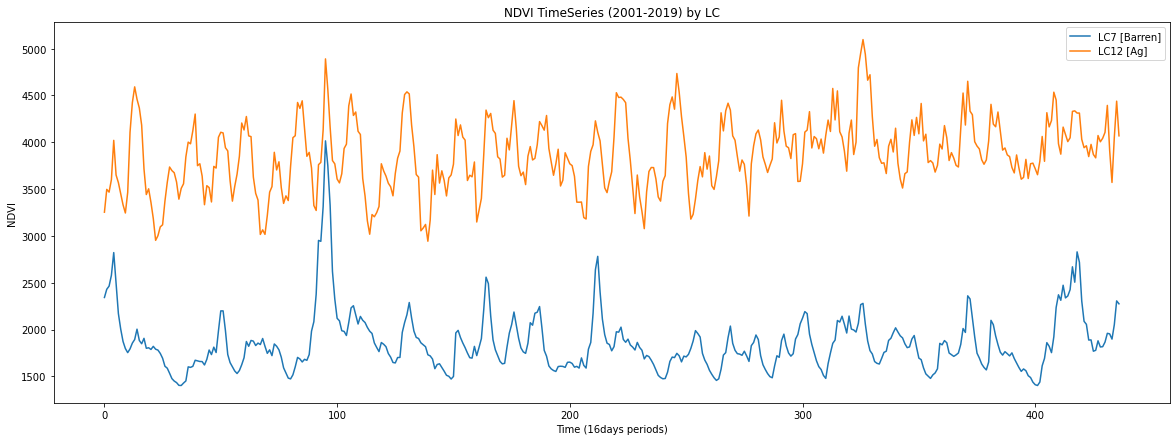

In [8]:
print("Creating a NDVI timeseries by Land Cover...")
startTime=vip.startTime()

#land cover type: Ag=12
print("Getting Timeseries for LC=12 (Ag)")
mask= (LandCover == 12)
NDVI_LC12=getTimeSeries_Masked(NDVICube,mask,NDVImin,NDVImax)

#land cover type: bare=7
LC7=7
print("Getting Timeseries for LC=7")
mask= (LandCover == 7)
NDVI_LC7=getTimeSeries_Masked(NDVICube,mask,NDVImin,NDVImax)


print("Plotting Land Cover TimeSeries")
plt.figure(figsize=(20,7))
plt.plot(NDVI_LC7,label='LC7 [Barren]')
plt.plot(NDVI_LC12,label='LC12 [Ag]')
plt.legend(loc='upper right')
plt.title('NDVI TimeSeries (2001-2019) by LC')
plt.ylabel('NDVI')
plt.xlabel('Time (16days periods)')
vip.endTime(startTime)

## 4. Summarize NDVI data into Yearly NDVI (filtered by RANK)

In [9]:
print(" Reducing NDVI data to Yearly.. It may take some time")
startTime=vip.startTime()
#create band arrays to store 15 daily images
NDVIYearlyCube=np.zeros((nrows,ncols,NYEARS),np.int16) 
NYEARS=19
for y in range(0,NYEARS):
   year=2001+y 
   indexA=y*23
   indexB=indexA+22
   print("Year=",year,"index:",indexA,"to",indexB)
   XData=Compute_NDVI_Yearly2(NDVICube, RANKCube, indexA, indexB, NDVImin, NDVImax, FILL_VI)
   NDVIYearlyCube[:,:,y]=XData
vip.endTime(startTime,"\nDone:")

 Reducing NDVI data to Yearly.. It may take some time
Year= 2001 index: 0 to 22
Year= 2002 index: 23 to 45
Year= 2003 index: 46 to 68
Year= 2004 index: 69 to 91
Year= 2005 index: 92 to 114
Year= 2006 index: 115 to 137
Year= 2007 index: 138 to 160
Year= 2008 index: 161 to 183
Year= 2009 index: 184 to 206
Year= 2010 index: 207 to 229
Year= 2011 index: 230 to 252
Year= 2012 index: 253 to 275
Year= 2013 index: 276 to 298
Year= 2014 index: 299 to 321
Year= 2015 index: 322 to 344
Year= 2016 index: 345 to 367
Year= 2017 index: 368 to 390
Year= 2018 index: 391 to 413
Year= 2019 index: 414 to 436

Done: 2.57  seconds


## 5. Extract Time Series from the yearly Data

Timeseries extraction for some pixels from Yearly Dataset
.


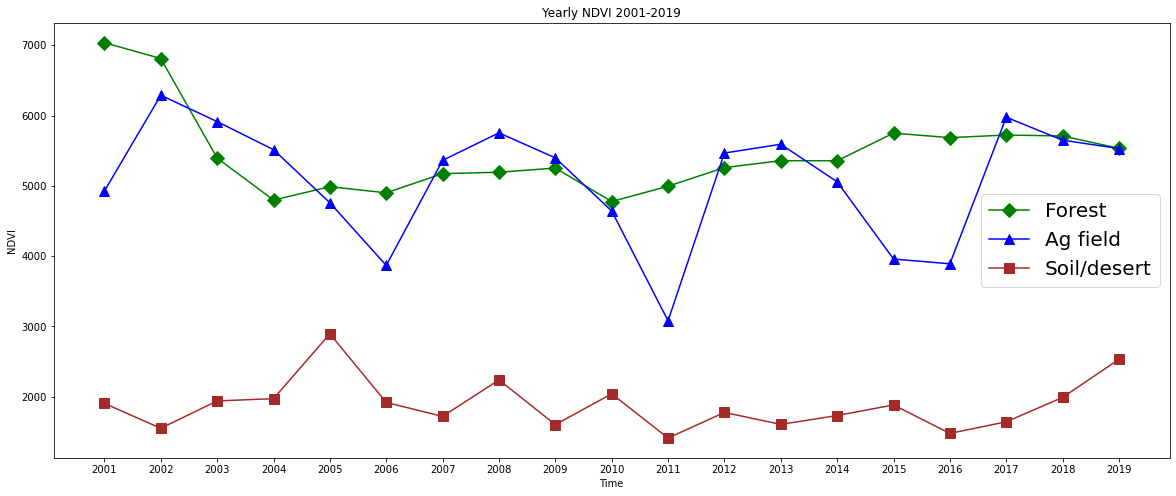

In [10]:
print("Timeseries extraction for some pixels from Yearly Dataset")
# Extract Timeseries for a few locations and plot them
TSndvi_Forest=NDVIYearlyCube[228,245,:]
TSndvi_Ag=NDVIYearlyCube[48,62,:]
TSndvi_Soil=NDVIYearlyCube[221,100,:]

#create a list with year values as labels
XYears=[]
for i in range(2001,2020):
    year=''+str(i)
    XYears.append(year)    

plt.figure(figsize=(20,8))
plt.title('Yearly NDVI 2001-2019')
plt.ylabel('NDVI')
plt.xlabel('Time')


plt.plot(XYears,TSndvi_Forest,color='green',label='Forest',marker = 'D', ms = 10)
plt.plot(XYears,TSndvi_Ag,color='blue',label='Ag field',marker = '^', ms = 10)
plt.plot(XYears,TSndvi_Soil,color='brown',label='Soil/desert',marker = 's', ms = 10)
plt.legend(fontsize=20)
print(".")

## 6. Compute Avg and Stdev for a pixel timeseries

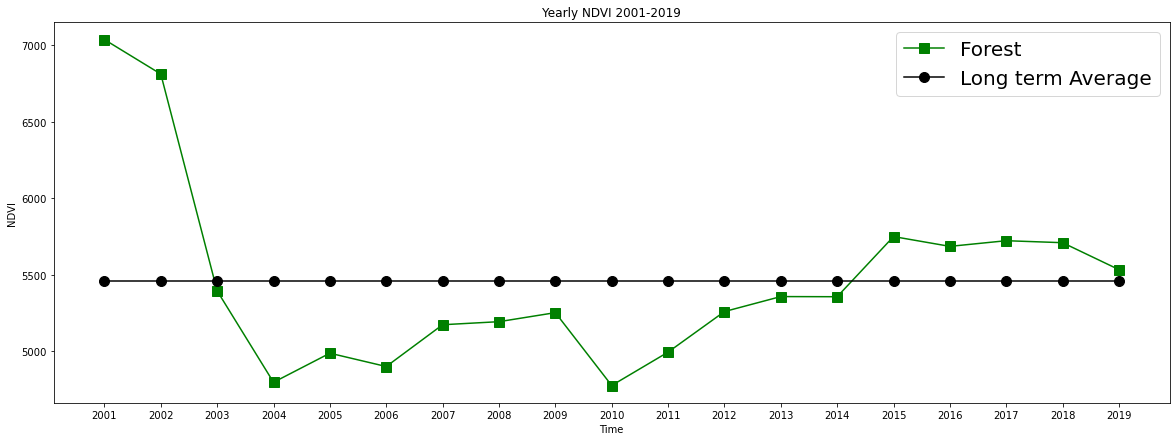

In [11]:
# Compute Avg and Stdev for a TimeSeries

Forest_Avg=np.mean(TSndvi_Forest)
Forest_Stdev=np.std(TSndvi_Forest)

# also plot the average value
Yavg=np.zeros((19))
Yavg[:]=Forest_Avg


# Plot Timeseries with avg
plt.figure(figsize=(20,7))
plt.title('Yearly NDVI 2001-2019')
plt.ylabel('NDVI')
plt.xlabel('Time')
plt.plot(XYears,TSndvi_Forest,color='green',label='Forest',marker = 's', ms = 10)
plt.plot(XYears,Yavg,color='k',label='Long term Average',marker = 'o', ms = 10)
plt.legend(fontsize=20, loc='upper right')

## 7. Compute SD Anomaly from a timeseries

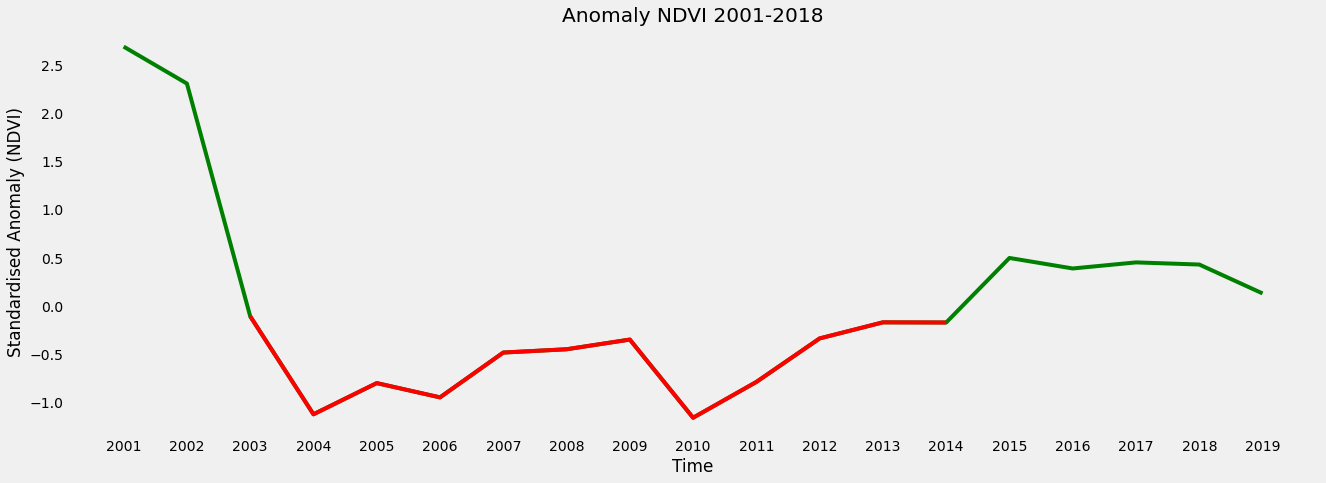

In [24]:
# Compute SD Anomaly
# Anomaly 

Anomaly=(TSndvi_Forest-Forest_Avg) / Forest_Stdev

#Now create positive and negative signals
Anomaly_Pos = Anomaly.copy()
Anomaly_Neg = Anomaly.copy()

Anomaly_Pos[Anomaly_Pos < 0] = np.nan
Anomaly_Neg[Anomaly_Neg >= 0] = np.nan

# Plot Timeseries with avg
plt.figure(figsize=(20,7))
plt.title('Anomaly NDVI 2001-2018')
plt.ylabel('Standardised Anomaly (NDVI)')
plt.xlabel('Time')
plt.plot(XYears,Anomaly,color='green',label='Forest')
plt.plot(XYears,Anomaly_Neg,color='red')
plt.grid()
plt.legend()

## 8. Compute NDVI avg and NDVI stdev for full image

Computing AVG and STDEV for full image. Wait...
 1.62  seconds


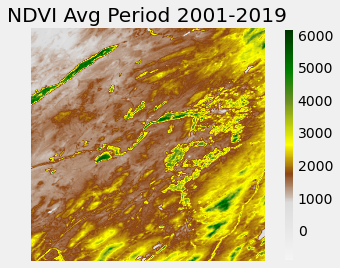

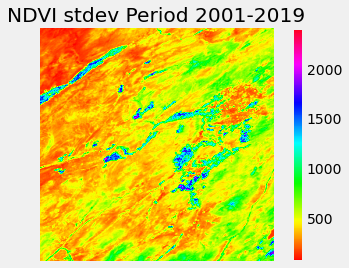

In [25]:
# Compute Standarized anomalies for full dataset
print("Computing AVG and STDEV for full image. Wait...")
startTime=vip.startTime()

NDVI_avg,NDVI_stdev=Compute_AVG_STDEV2(NDVICube,NDVImin,NDVImax,FILL_VI)
vip.endTime(startTime)

# display AVG and STDEV images

# use NDVI custom color map
valueList  = [-0.6, -0.2, 0.,0.2, 0.5, 0.7, 1]  # Define the color nodes 
colorList = ["whitesmoke","gainsboro","saddlebrown","yellow","olivedrab","green","#003000"]  # Define the colors for each node 
cmapNDVI=vip.createColorMap([valueList,colorList],plt)

plt.figure()
plt.title('NDVI Avg Period 2001-2019')
plt.imshow(NDVI_avg,cmap=cmapNDVI)
plt.axis('off')
plt.colorbar()

plt.figure()
plt.title('NDVI stdev Period 2001-2019')
plt.imshow(NDVI_stdev,cmap='hsv')
plt.axis('off')
plt.colorbar()

## 6. Homework (see presentation)

# a) Save Yearly NDVI Cube to HDF or BSQ file

In [52]:
#put your code here

# b) Display all Yearly NDVI images

In [53]:
#put your code here

# c) Display Timeseries for all Land Cover classes in the Image (By cycle and yearly)

In [54]:
#put your code here

# d) Display SD yearly anomalies for all Land Cover classes in the Image

In [55]:
#put your code here

# e) Compute SD Anomaly as Image and Display every year

In [56]:
#your code here

In [57]:
print("program ended.")

program ended.
